# Multi-Class Tabular Model for Dry Bean Identification Using Python and XGBoost
### David Lowe
### June 2, 2022

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Dry Bean Identification dataset is a multi-class modeling situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: There is a wide range of genetic diversity in dry beans, the most produced one among the edible legume crops in the world. Seed classification is essential for the marketing and production of sustainable agricultural systems. The primary objective of this research study is to provide a method for obtaining uniform seed varieties from crop production. The research team developed a computer vision system to classify seven different types of dry beans with similar features. For the classification model, the researchers used a high-resolution camera to gather 13,611 images of dry beans.

ANALYSIS: The performance of the preliminary XGBoost model achieved an accuracy benchmark of 92.61%. After a series of tuning trials, the final model processed the training dataset with an accuracy score of 92.97%. When we processed the test dataset with the final model, the model achieved an accuracy score of 91.77%.

CONCLUSION: In this iteration, the XGBoost model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Dry Bean Dataset

Dataset ML Model: Multi-Class classification with numerical features

Dataset Reference: https://www.muratkoklu.com/datasets/

One source of potential performance benchmarks: https://doi.org/10.1016/j.compag.2020.105507

## Task 1 - Prepare Environment

In [1]:
# Retrieve the GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Mon May 23 17:04:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    45W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Retrieve the memory configuration
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 89.6 gigabytes of available RAM



In [3]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 12


### 1.a) Load libraries and modules

In [4]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
import zipfile
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the name for the class/label column
ORIGINAL_LABEL = 'Class'
CLASS_COLUMN = 'target'

# Set the number of folds for cross validation
N_FOLDS = 5

# Set default modeling scoring metric
SCORING_METRIC = 'accuracy'

# Define the directory locations and file names
TRAIN_DATASET = 'Durum_Wheat_Features.csv'

In [7]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [8]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [9]:
dataset_path = 'https://dainesanalytics.com/datasets/muratkoklu-dry-bean-dataset/Dry_Bean_Dataset.arff'
colNames = ['Area','Perimeter','MajorAxisLength','MinorAxisLength','AspectRation','Eccentricity','Convex_Area','EquivDiameter',
            'Extent','Solidity','Roundness','Compactness','ShapeFactor1','ShapeFactor2','ShapeFactor3','ShapeFactor4','Class']
df_dataset_import = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False, skiprows=25)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

    Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  28395    610.291       208.178117       173.888747      1.197191   
1  28734    638.018       200.524796       182.734419      1.097356   
2  29380    624.110       212.826130       175.931143      1.209713   
3  30008    645.884       210.557999       182.516516      1.153638   
4  30140    620.134       201.847882       190.279279      1.060798   

   Eccentricity  Convex_Area  EquivDiameter    Extent  Solidity  Roundness  \
0      0.549812        28715     190.141097  0.763923  0.988856   0.958027   
1      0.411785        29172     191.272750  0.783968  0.984986   0.887034   
2      0.562727        29690     193.410904  0.778113  0.989559   0.947849   
3      0.498616        30724     195.467062  0.782681  0.976696   0.903936   
4      0.333680        30417     195.896503  0.773098  0.990893   0.984877   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  
0     0.913358      0.00

In [10]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   Convex_Area      13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  Roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

In [11]:
print(df_dataset_import.describe())

                Area     Perimeter  MajorAxisLength  MinorAxisLength  \
count   13611.000000  13611.000000     13611.000000     13611.000000   
mean    53048.284549    855.283459       320.141867       202.270714   
std     29324.095717    214.289696        85.694186        44.970091   
min     20420.000000    524.736000       183.601165       122.512653   
25%     36328.000000    703.523500       253.303633       175.848170   
50%     44652.000000    794.941000       296.883367       192.431733   
75%     61332.000000    977.213000       376.495012       217.031741   
max    254616.000000   1985.370000       738.860153       460.198497   

       AspectRation  Eccentricity    Convex_Area  EquivDiameter        Extent  \
count  13611.000000  13611.000000   13611.000000   13611.000000  13611.000000   
mean       1.583242      0.750895   53768.200206     253.064220      0.749733   
std        0.246678      0.092002   29774.915817      59.177120      0.049086   
min        1.024868      0.

In [12]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
Convex_Area        0
EquivDiameter      0
Extent             0
Solidity           0
Roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Class              0
dtype: int64
Total number of NaN in the dataframe:  0


In [13]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(ORIGINAL_LABEL).size())

Class
BARBUNYA    1322
BOMBAY       522
CALI        1630
DERMASON    3546
HOROZ       1928
SEKER       2027
SIRA        2636
dtype: int64


### 1.d) Data Cleaning

In [14]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

    Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  28395    610.291       208.178117       173.888747      1.197191   
1  28734    638.018       200.524796       182.734419      1.097356   
2  29380    624.110       212.826130       175.931143      1.209713   
3  30008    645.884       210.557999       182.516516      1.153638   
4  30140    620.134       201.847882       190.279279      1.060798   

   Eccentricity  Convex_Area  EquivDiameter    Extent  Solidity  Roundness  \
0      0.549812        28715     190.141097  0.763923  0.988856   0.958027   
1      0.411785        29172     191.272750  0.783968  0.984986   0.887034   
2      0.562727        29690     193.410904  0.778113  0.989559   0.947849   
3      0.498616        30724     195.467062  0.782681  0.976696   0.903936   
4      0.333680        30417     195.896503  0.773098  0.990893   0.984877   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4 target  
0     0.913358      0.00

In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   Convex_Area      13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  Roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  target           13611 non-null  object 
dtypes: float64(1

In [16]:
print(df_dataset_import.describe())

                Area     Perimeter  MajorAxisLength  MinorAxisLength  \
count   13611.000000  13611.000000     13611.000000     13611.000000   
mean    53048.284549    855.283459       320.141867       202.270714   
std     29324.095717    214.289696        85.694186        44.970091   
min     20420.000000    524.736000       183.601165       122.512653   
25%     36328.000000    703.523500       253.303633       175.848170   
50%     44652.000000    794.941000       296.883367       192.431733   
75%     61332.000000    977.213000       376.495012       217.031741   
max    254616.000000   1985.370000       738.860153       460.198497   

       AspectRation  Eccentricity    Convex_Area  EquivDiameter        Extent  \
count  13611.000000  13611.000000   13611.000000   13611.000000  13611.000000   
mean       1.583242      0.750895   53768.200206     253.064220      0.749733   
std        0.246678      0.092002   29774.915817      59.177120      0.049086   
min        1.024868      0.

In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
Convex_Area        0
EquivDiameter      0
Extent             0
Solidity           0
Roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
target             0
dtype: int64
Total number of NaN in the dataframe:  0


In [18]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(CLASS_COLUMN).size())

target
BARBUNYA    1322
BOMBAY       522
CALI        1630
DERMASON    3546
HOROZ       1928
SEKER       2027
SIRA        2636
dtype: int64


### 1.e) Splitting Data into Sets

In [19]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_import = df_dataset_import['target']
df_features_import = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))

df_dataset_import.shape: (13611, 17) df_features_import.shape: (13611, 16) df_target_import.shape: (13611,)


In [20]:
# Split the data further into training and test datasets
df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features_import, df_target_import,
                                                                                        test_size=TEST_SET_RATIO, random_state=RNG_SEED,
                                                                                        stratify=df_target_import)
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))
print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_train.shape: (12249, 16) df_target_train.shape: (12249,)
df_features_test.shape: (1362, 16) df_target_test.shape: (1362,)


### 1.f) Set up the parameters for data visualization

In [21]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [22]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [23]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

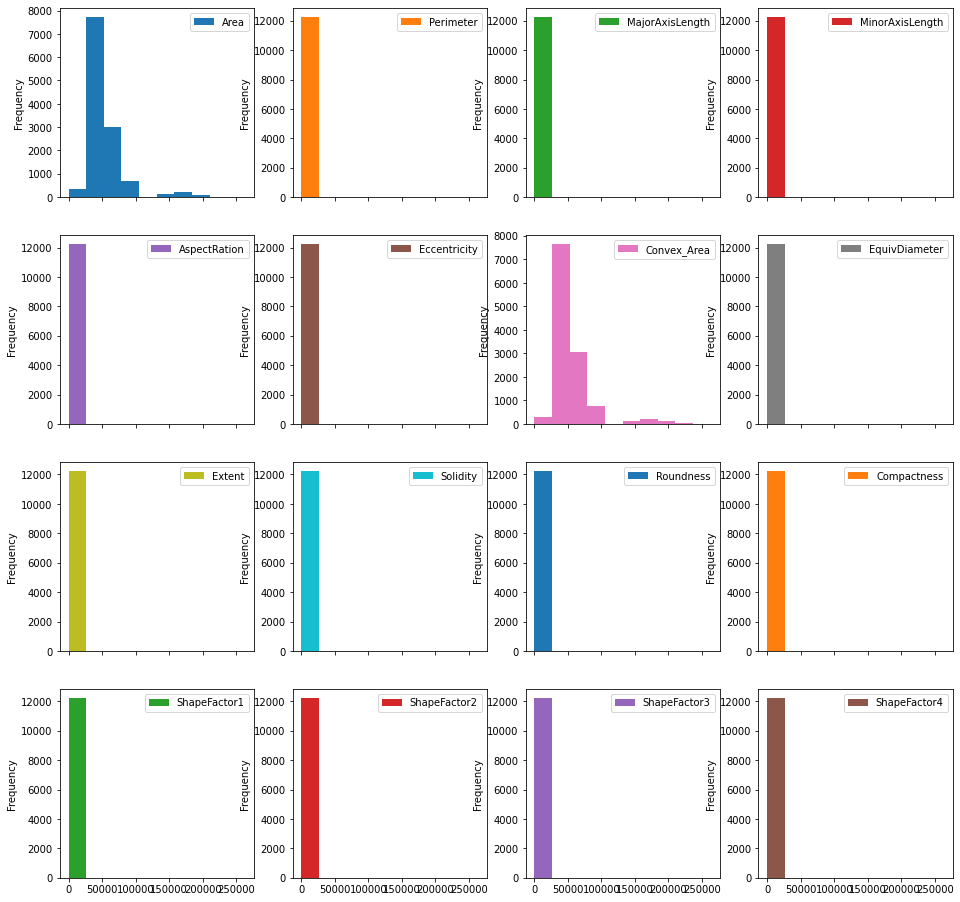

In [24]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

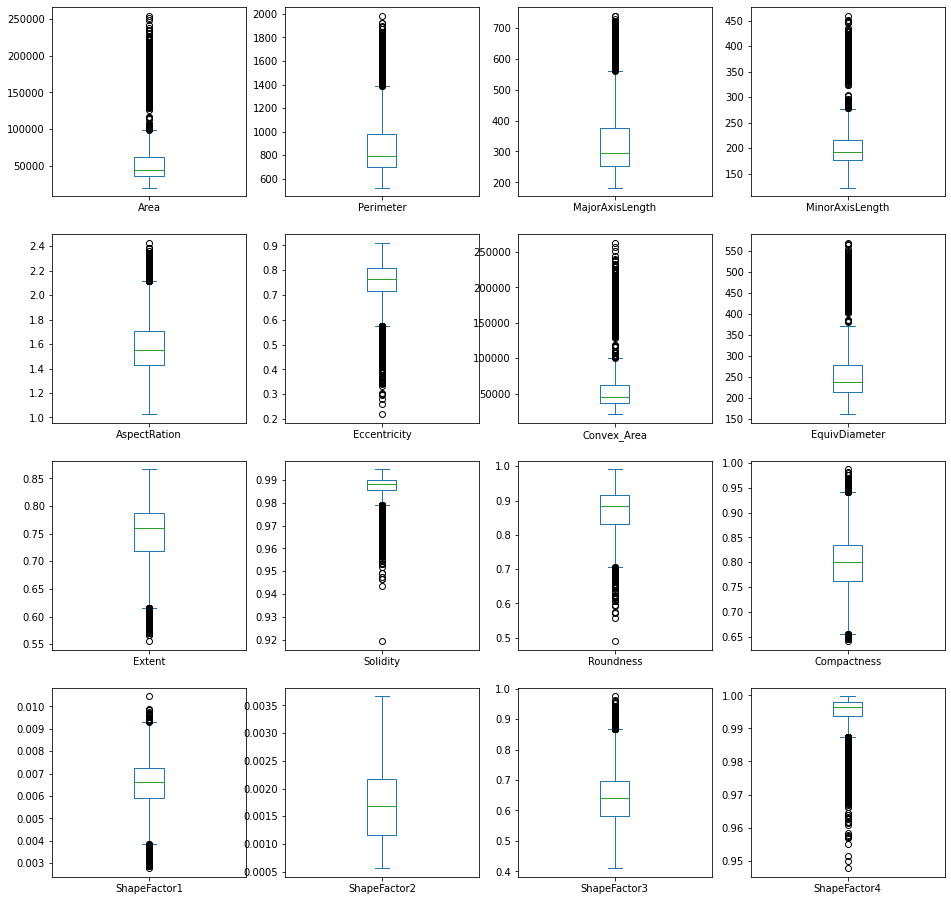

In [25]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

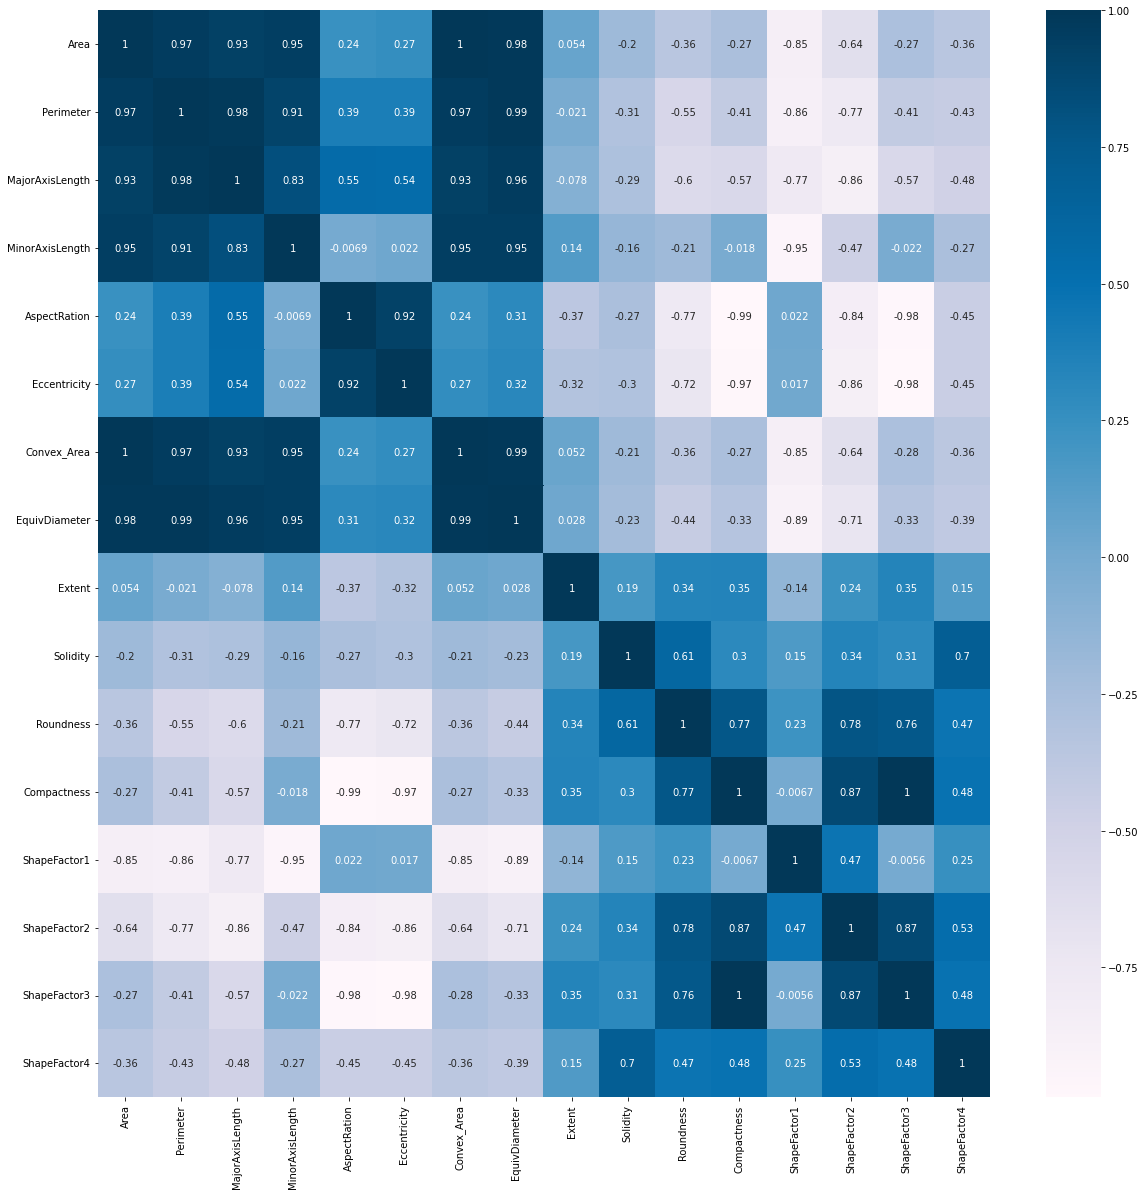

In [26]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [28]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [29]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 16
Number of categorical columns: 0
Total number of columns in the feature dataframe: 16


In [30]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (12249, 16) to array_features_train.shape: (12249, 16)


### 3.b) Training Data Balancing

In [31]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [32]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [33]:
# Finalize the training dataset for the modeling activities
array_features_train = preprocessor.fit_transform(df_features_train)
label_encoder = preprocessing.LabelEncoder()
array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (12249, 16) array_target_train.shape: (12249,)


In [34]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [35]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [36]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [37]:
train_models.append(('XGB', XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='multi:softmax', use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')))

In [38]:
# Generate model in turn
for name, model in train_models:
    if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
    start_time_module = datetime.now()
    kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
    cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
    train_results.append(cv_results)
    train_model_names.append(name)
    train_metrics.append(cv_results.mean())
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
    print(model)
    print ('Model training time:', (datetime.now() - start_time_module), '\n')
    if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print ('Total training time for all models:', (datetime.now() - start_time_training))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGB: 0.926199 (0.007817)
XGBClassifier(eval_metric='mlogloss', objective='multi:softmax',
              random_state=888, tree_method='gpu_hist',
              use_label_encoder=False)
Model training time: 0:00:55.728056 

Average metrics (accuracy) from all models: 0.9261987816768193
Total training time for all models: 0:00:55.753059


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.7s finished


### 4.b) Algorithm Tuning

In [39]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [40]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight parameters
start_time_Module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(100, 501, 100),
                  max_depth=np.array([3, 6, 9]),
                  min_child_weight=np.array([1, 2, 3]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_Module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best: 0.929627 using {'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100}
0.926199 (0.007817) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
0.927423 (0.007080) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
0.929382 (0.006066) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
0.926443 (0.006640) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400}
0.926525 (0.006170) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
0.926199 (0.008101) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100}
0.928076 (0.007487) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200}
0.928648 (0.007340) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}
0.928403 (0.006595) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 400}
0.928648 (0.006209) with: {'max_depth': 3, 'min_child_weight': 2, 'n_esti

In [41]:
BEST_MAX_DEPTH = grid_result1.best_params_['max_depth']
BEST_MIN_CHILD_WEIGHT = grid_result1.best_params_['min_child_weight']
BEST_N_ESTIMATORS = grid_result1.best_params_['n_estimators']
print('Best max_depth parameter:', BEST_MAX_DEPTH)
print('Best min_child_weight parameter:', BEST_MIN_CHILD_WEIGHT)
print('Best n_estimators parameter:', BEST_N_ESTIMATORS)

Best max_depth parameter: 6
Best min_child_weight parameter: 3
Best n_estimators parameter: 100


In [42]:
# Tuning XGBoost subsample and colsample_bytree parameters
start_time_Module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')
tune_model_names.append('XGB_2')
paramGrid2 = dict(subsample=np.array([0.7, 0.8, 0.9, 1.0]),
                  colsample_bytree=np.array([0.7, 0.8, 0.9, 1.0]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_Module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best: 0.929709 using {'colsample_bytree': 1.0, 'subsample': 0.9}
0.928403 (0.008058) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
0.928403 (0.007092) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
0.928648 (0.007694) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
0.928076 (0.006585) with: {'colsample_bytree': 0.7, 'subsample': 1.0}
0.928403 (0.008512) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
0.929464 (0.007110) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
0.928811 (0.007852) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
0.928076 (0.006944) with: {'colsample_bytree': 0.8, 'subsample': 1.0}
0.928076 (0.007958) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
0.929464 (0.007655) with: {'colsample_bytree': 0.9, 'subsample': 0.8}
0.928321 (0.007730) with: {'colsample_bytree': 0.9, 'subsample': 0.9}
0.928076 (0.007669) with: {'colsample_bytree': 0.9, 'subsample': 1.0}
0.928648 (0.007255) with: {'colsam

In [43]:
BEST_COLSAMPLE_BYTREE = grid_result2.best_params_['colsample_bytree']
BEST_SUBSAMPLE = grid_result2.best_params_['subsample']
print('Best colsample_bytree parameter:', BEST_COLSAMPLE_BYTREE)
print('Best subsample parameter:', BEST_SUBSAMPLE)

Best colsample_bytree parameter: 1.0
Best subsample parameter: 0.9


### 4.c) Compare Algorithms After Tuning

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


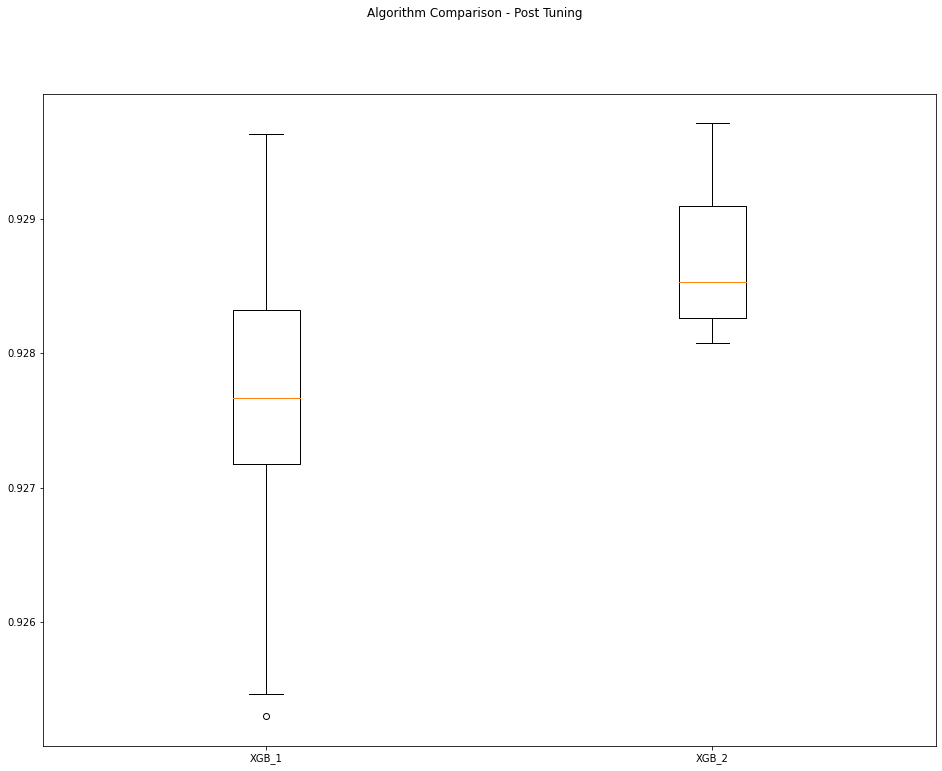

In [44]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [45]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [46]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [47]:
final_model = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            colsample_bytree=BEST_COLSAMPLE_BYTREE, subsample=BEST_SUBSAMPLE, random_state=RNG_SEED,
                            n_jobs=N_JOBS, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')
final_model.fit(array_features_train, array_target_train)
print(final_model)

XGBClassifier(colsample_bytree=1.0, eval_metric='mlogloss', max_depth=6,
              min_child_weight=3, objective='multi:softprob', random_state=888,
              subsample=0.9, tree_method='gpu_hist', use_label_encoder=False)


### 5.b) Load Test Dataset and Make Predictions

In [48]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
array_target_test = label_encoder.transform(df_target_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (1362, 16) to array_features_test.shape: (1362, 16)


In [49]:
# Make batched predictions
test_predictions =  final_model.predict(array_features_test)
print(test_predictions)

[6 2 6 ... 4 0 5]


In [50]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions))
print(confusion_matrix(array_target_test, test_predictions))
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 0.9177679882525698
[[126   0   3   0   0   0   3]
 [  0  52   0   0   0   0   0]
 [  4   0 152   0   6   0   1]
 [  0   0   0 327   2   6  20]
 [  1   0   1   2 184   0   5]
 [  0   0   0   7   0 184  12]
 [  2   0   1  29   5   2 225]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       132
           1       1.00      1.00      1.00        52
           2       0.97      0.93      0.95       163
           3       0.90      0.92      0.91       355
           4       0.93      0.95      0.94       193
           5       0.96      0.91      0.93       203
           6       0.85      0.85      0.85       264

    accuracy                           0.92      1362
   macro avg       0.94      0.93      0.93      1362
weighted avg       0.92      0.92      0.92      1362



In [51]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [52]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:17:12.518459
